# Headfixed odor exposure

In [1]:
output_dir = './data/headfixed_peanut'
filename = './data/headfixed_180328.h5'
neural_type = 'Traces'
odor_to_use = 'PNT'

In [2]:
%matplotlib inline
# %matplotlib
# %load_ext rpy2.ipython
%load_ext autoreload

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import h5py as h5
import os
import time
import itertools
import statsmodels.formula.api as smf
import scipy.stats
import scipy.signal as signal
import scipy.io as sio

from sklearn import linear_model, cluster, decomposition, manifold
from sklearn.metrics import silhouette_score
import networkx as nx

import custom
import utilities
from utilities import savefig

C:\Users\Randall\Anaconda3\envs\py2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


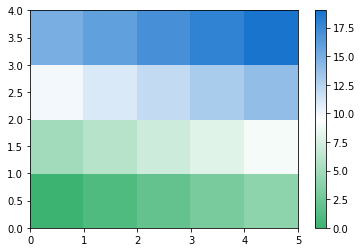

In [3]:
cmap = custom.diverging_cmap(np.array([60, 179, 113]) / 255., np.array([24, 116, 205]) / 255.)
plt.pcolor(np.arange(20).reshape(4, 5), cmap=cmap)
plt.colorbar()

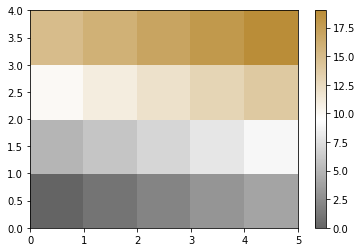

In [4]:
cmap2 = custom.diverging_cmap(np.array([100, 100, 100]) / 255., np.array([186, 141, 56]) / 255.)
plt.pcolor(np.arange(20).reshape(4, 5), cmap=cmap2)
plt.colorbar()

In [5]:
# Output paramters

opts_fig = {
    'dpi': 300,
    'frameon': False,
    'bbox_inches': 'tight',
    'transparent': True
}

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

# Import and setup data

In [6]:
# Parameters

frame_dur = 200
epochs = ['base', 'h2o', 'odor']
trial_slice = slice(0, 2)  # Trials to include (out of 5)
epoch_ctrl = 'h2o'
epoch_exp = 'odor'
odor_pnt = 'PNT'
odor_tmt = 'TMT'

## Import data
Import particular odor (peanut oil vs TMT) and data type (events vs trace).

In [7]:
# Import data

with pd.HDFStore(filename, mode='r') as hf:
    # Take first odor (TMT vs peanut oil) only
    df_behav = hf['behav'].loc[:, (odor_to_use, slice(None), 'P1', 'A')]
    df_neural = hf['neural'][neural_type].loc[:, (odor_to_use, slice(None), 'P1', 'A')].astype(float)  # need to cast since it's object type
    
    # Clean up
    df_behav.columns = df_behav.columns.droplevel(['experiment', 'order', 'plane'])
    df_neural.columns = df_neural.columns.droplevel(['experiment', 'order', 'plane'])

## Check data

In [ ]:
samples = np.random.choice(df_neural.columns, size=25)
fig, axes = plt.subplots(5, 5, sharey=True, sharex=True, figsize=(10, 10))
fig.suptitle('CNMF traces')
for ax, sample in zip(axes.flatten(), samples):
    df_neural[sample].plot(ax=ax, legend=False)
    ax.set_title('_'.join([str(x) for x in sample]))
fig.tight_layout()

In [ ]:
pupil = df_behav.xs('pupil', axis=1, level='feature')
n_exps = pupil.shape[1]
fx = fy = int(np.ceil(np.sqrt(n_exps)))
fig, axes = plt.subplots(nrows=fx, ncols=fy, sharex=True, sharey=True, figsize=(10, 10))
fig.suptitle('Pupil pre normal')
for ax, exp in zip(axes.flatten(), pupil.columns):
    pupil[exp].plot(ax=ax)
    ax.set_title(' '.join(exp))

fig.tight_layout()

In [ ]:
track = df_behav.xs('track', axis=1, level='feature')
n_exps = track.shape[1]
fx = fy = int(np.ceil(np.sqrt(n_exps)))

fig, axes = plt.subplots(nrows=fx, ncols=fy, sharex=True, sharey=True, figsize=(10, 10))
fig.suptitle('Track pre normal')
for ax, exp in zip(axes.flatten(), track.columns):
    track[exp].plot(ax=ax)
    ax.set_title(' '.join(exp))

fig.tight_layout()

## Normalize data

Data is **scaled** so that one unit is equal to standard deviation (calculated on _entire_ recording of a particular neuron).  
Data is **centered** on its mean (across _entire_ recording).

Later, data will be centered on mean of trial baseline.

In [8]:
# Standardize variance (std = 1) to baseline
df_neural_norm = (df_neural - df_neural.loc[epoch_ctrl].median()) / df_neural.loc[epoch_ctrl].std()
# df_neural_norm = df_neural / df_neural.loc[epoch_ctrl].std()
# stds = df_neural.loc[epoch_ctrl].std()
# df_neural_norm = df_neural * (1 / stds)

In [ ]:
bad_stds_ix = stds.index[stds < 0.01].tolist()
df_neural_norm = df_neural_norm.drop(bad_stds_ix, axis=1)

In [ ]:
stds[stds < 0.01].index.tolist()

In [ ]:
df_neural_norm.max()

Behavior data is standardized (divide by standard deviation). Track is NOT centered on its mean. Absolute data is taken on track to get 'movement' measure.

In [9]:
# Clean & normalize

df_behav_orig = df_behav.copy()

filtered = df_behav.loc[:, (slice(None), ['pupil', 'track'])].groupby(level='epoch').rolling(5, center=True).median()
filtered.index = filtered.index.droplevel(1)
df_behav.loc[:, (slice(None), ['pupil', 'track'])] = filtered

pupil_mean = df_behav.loc[epoch_ctrl, (slice(None), 'pupil')].mean()
pupil_std = df_behav.loc[epoch_ctrl, (slice(None), 'pupil')].std()
df_behav.loc[:, (slice(None), 'pupil')] -= pupil_mean
df_behav.loc[:, (slice(None), 'pupil')] *= 1 / pupil_std

# Normalize track
# Take absolute value to capture 'movement'
track_slice = (slice(None), 'track')
df_behav.loc[:, track_slice] = np.abs(df_behav.loc[:, track_slice])

rolling median doesn't handle `nan` ideally. Will return `nan` if `nan` is within window.

# Overview

In [11]:
# Parameters
pre = -12000
post = 22000
bin_size = 200
xticklabels = np.arange(-10000, 22000, 5000)
xticks = (xticklabels - pre) / bin_size

In [12]:
# Create trial structure

df = pd.concat([df_behav, df_neural_norm], axis=1)
df = df.sort_index(axis=1)
df_trials = utilities.pupil_trials(df, bin_size=bin_size, pre=pre, post=post)

# Break up data into neural and behavioral
neural = df_trials.iloc[:, [not isinstance(s, basestring) for s in df_trials.columns.get_level_values(2)]]
neural.columns.names = df_trials.columns.names[:-1] + ['neuron']
behav = df_trials.iloc[:, [isinstance(s, basestring) for s in df_trials.columns.get_level_values(2)]]
behav.columns.names = df_trials.columns.names[:-1] + ['feature']

# Add epoch names
neural.loc[:, 'time_epoch'] = [
    '0 pre' if -12000 <= ts < -6000 else
    '1 na' if -6000 <= ts < 0 else
    '2 response' if 0 <= ts < 10000 else
    '3 na' if 10000 <= ts < 16000 else
    '4 post' if 16000 <= ts < 22000 else
    'na'
    for ts in neural.reset_index('trial_time')['trial_time']
]
neural = neural.set_index('time_epoch', append=True).reorder_levels(['epoch', 'time_epoch', 'trial_time'])

behav.loc[:, 'time_epoch'] = [
    '0 pre' if -12000 <= ts < -6000 else
    '1 na' if -6000 <= ts < 0 else
    '2 response' if 0 <= ts < 10000 else
    '3 na' if 10000 <= ts < 16000 else
    '4 post' if 16000 <= ts < 22000 else
    'na'
    for ts in behav.reset_index('trial_time')['trial_time']
]
behav = behav.set_index('time_epoch', append=True).reorder_levels(['epoch', 'time_epoch', 'trial_time'])

# Center data on trial baseline
neural_base_mean = neural.loc[(slice(None), '0 pre'), :].mean(level='epoch')
neural_centered = neural - neural_base_mean

behav_base_mean = behav.loc[(slice(None), '0 pre'), :].mean(level='epoch')
behav_centered = behav - behav_base_mean

C:\Users\Randall\Anaconda3\envs\py2\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Randall\Anaconda3\envs\py2\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Saved ./data/headfixed_peanut\track_by_trial


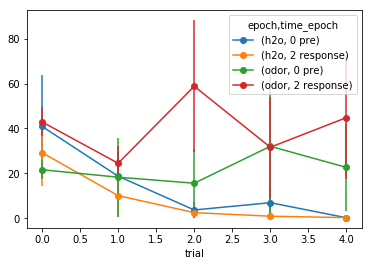

In [13]:
plt_name = 'track_by_trial'

track_by_trial = behav.loc[(['h2o', 'odor'], ['0 pre', '2 response']), (slice(None), slice(None), 'track')].mean(axis=0, level=['epoch', 'time_epoch'])
track_diff_by_trial = (track_by_trial.xs('2 response', level='time_epoch') - track_by_trial.xs('0 pre', level='time_epoch'))

fig, ax = plt.subplots()
# Y = track_diff_by_trial.mean(axis=1, level='trial').T
# E = track_diff_by_trial.sem(axis=1, level='trial').T
Y = track_by_trial.mean(axis=1, level='trial').T
E = track_by_trial.sem(axis=1, level='trial').T
Y.plot(ax=ax, yerr=E, marker='o')

if plt_name:
    savefig(os.path.join(output_dir, plt_name), fig)
    track_by_trial.to_csv(os.path.join(output_dir, plt_name + '.csv'))

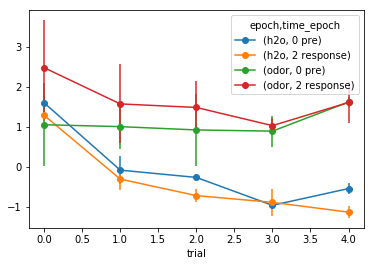

In [14]:
plt_name = 'pupil_by_trial'
# plt_name = ''

pupil_by_trial = behav.loc[(['h2o', 'odor'], ['0 pre', '2 response']), (slice(None), slice(None), 'pupil')].mean(axis=0, level=['epoch', 'time_epoch'])
pupil_diff_by_trial = (pupil_by_trial.xs('2 response', level='time_epoch') - pupil_by_trial.xs('0 pre', level='time_epoch'))

fig, ax = plt.subplots()
# Y = pupil_diff_by_trial.mean(axis=1, level='trial').T
# E = pupil_diff_by_trial.sem(axis=1, level='trial').T
Y = pupil_by_trial.mean(axis=1, level='trial').T
E = pupil_by_trial.sem(axis=1, level='trial').T
Y.plot(ax=ax, yerr=E, marker='o')

if plt_name:
    savefig(os.path.join(output_dir, plt_name), fig)
    pupil_by_trial.to_csv(os.path.join(output_dir, plt_name + '.csv'))

Saved ./data/headfixed_peanut\neural_by_trial


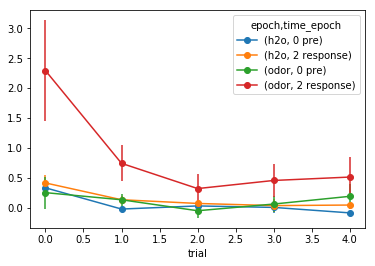

In [15]:
plt_name = 'neural_by_trial'

neural_by_trial = neural.loc[(['h2o', 'odor'], ['0 pre', '2 response']), :].mean(axis=0, level=['epoch', 'time_epoch']).mean(axis=1, level=['subject', 'trial'])
neural_diff_by_trial = (neural_by_trial.xs('2 response', level='time_epoch') - neural_by_trial.xs('0 pre', level='time_epoch'))

fig, ax = plt.subplots()
# Y = neural_diff_by_trial.mean(axis=1, level='trial').T
# E = neural_diff_by_trial.sem(axis=1, level='trial').T
Y = neural_by_trial.mean(axis=1, level='trial').T
E = neural_by_trial.sem(axis=1, level='trial').T
Y.plot(ax=ax, yerr=E, marker='o')

if plt_name:
    savefig(os.path.join(output_dir, plt_name), fig)
    neural_by_trial.to_csv(os.path.join(output_dir, plt_name + '.csv'))

In [16]:
trial_slice = slice(0, 1)
neural_response = neural.loc[:, (slice(None), trial_slice)]
behav_response = behav.loc[:, (slice(None), trial_slice)]

## Behavior

Saved ./data/headfixed_peanut\pupil_cb.svg


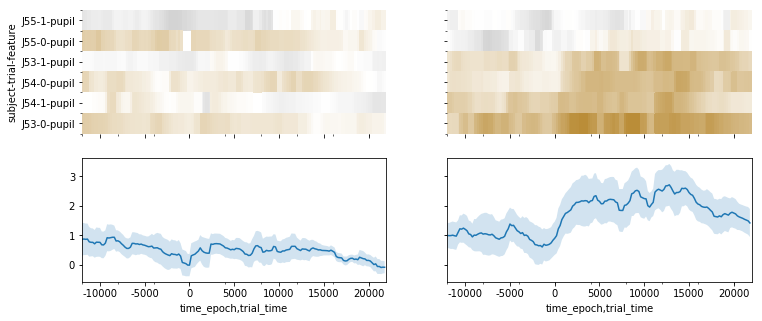

Saved ./data/headfixed_peanut\pupil.png
Saved ./data/headfixed_peanut\pupil.svg
Saved ./data/headfixed_peanut\track_cb.svg


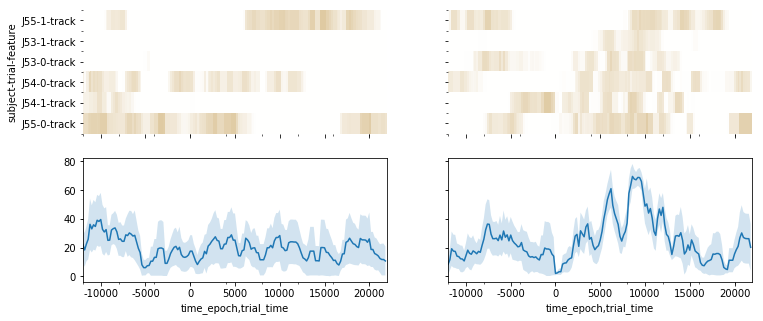

Saved ./data/headfixed_peanut\track.png
Saved ./data/headfixed_peanut\track.svg


In [17]:
# Pupil and velocity plots

def behavior_plots(data, plt_name=None, vmin=-2, vmax=2):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(12, 5))
    fig_cb, ax_cb = plt.subplots(figsize=(0.25, 4))
    
    for n, (epoch, df) in enumerate(data.groupby(axis=0, level='epoch')):
        df.index = df.index.droplevel('epoch')
        
        C = df.copy()
        C.index = C.index.droplevel('time_epoch')
        sns.heatmap(C.T, ax=axes[0, n], cbar_ax=ax_cb, center=0, cmap=cmap2, vmin=vmin, vmax=vmax)
        im = axes[0, n].collections[0]
        
        Y = df.mean(axis=1)
        E = df.sem(axis=1)
        Y.plot(ax=axes[1, n])
        X = axes[1, n].lines[0].get_xdata()
        axes[1, n].fill_between(X, Y + E, Y - E, alpha=0.2)
        axes[0, n].set_xticks(xticks)
        axes[0, n].set_xticklabels(xticklabels)
    
    # Show and save figures
    if plt_name: savefig(plt_name + '_cb.svg', fig_cb)
    plt.close(fig_cb)

    plt.show()
    if plt_name:
        savefig(plt_name + '.png', fig)
        im.remove()
        savefig(plt_name + '.svg', fig)

sort_ix = {
    'pupil': np.argsort(behav_response.loc[('odor', '2 response'), (slice(None), slice(None), 'pupil')].mean().as_matrix()),
    'track': np.argsort(behav_response.loc[('odor', '2 response'), (slice(None), slice(None), 'track')].mean().as_matrix()),
}
for feature, v in zip(['pupil', 'track'], [[-5, 5], [0, 250]]):
    plt_name = os.path.join(output_dir, feature)
    behavior_plots(behav_response.loc[['h2o', 'odor'], (slice(None), slice(None), feature)].iloc[:, sort_ix[feature]], plt_name, vmin=v[0], vmax=v[1])

In [ ]:
anova_data = behav.loc[(['h2o', 'odor'], ['0 pre', '2 response']), :].stack(level=['subject', 'trial'])
anova_data = anova_data.reorder_levels(['subject', 'trial', 'epoch', 'time_epoch', 'trial_time']).sort_index().reset_index()

In [ ]:
%%R -i anova_data

anova <- aov(track ~ time_epoch*epoch + Error(subject / (time_epoch*epoch)), data=anova_data)
summary(anova)

In [ ]:
%%R -i anova_data

anova <- aov(pupil ~ time_epoch*epoch + Error(subject / (time_epoch*epoch)), data=anova_data)
summary(anova)

Saved ./data/headfixed_peanut/behavior_by_time_epoch.png
Saved ./data/headfixed_peanut/behavior_by_time_epoch.svg


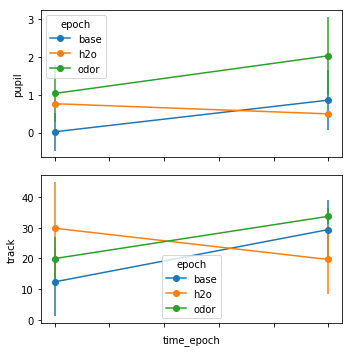

In [65]:
plt_name = 'behavior_by_time_epoch'

avg_data = behav_response.loc[(slice(None), ['0 pre', '2 response']), :].mean(axis=0, level=['epoch', 'time_epoch']).mean(axis=1, level=['subject', 'feature'])

Y = avg_data.mean(axis=1, level='feature')
E = avg_data.sem(axis=1, level='feature')

fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(5, 5))
Y['pupil'].unstack('epoch').plot(ax=axes[0], yerr=E['pupil'].unstack('epoch'), marker='o')
Y['track'].unstack('epoch').plot(ax=axes[1], yerr=E['track'].unstack('epoch'), marker='o')
axes[0].set_ylabel('pupil')
axes[1].set_ylabel('track')
fig.tight_layout()

if plt_name:
    savefig(os.path.join(output_dir, plt_name + '.png'), fig)
    savefig(os.path.join(output_dir, plt_name + '.svg'), fig)
    avg_data.to_csv(os.path.join(output_dir, plt_name + '.csv'))

## Neural data

Saved ./data/headfixed_peanut\sample_trace.png
Saved ./data/headfixed_peanut\sample_trace.svg


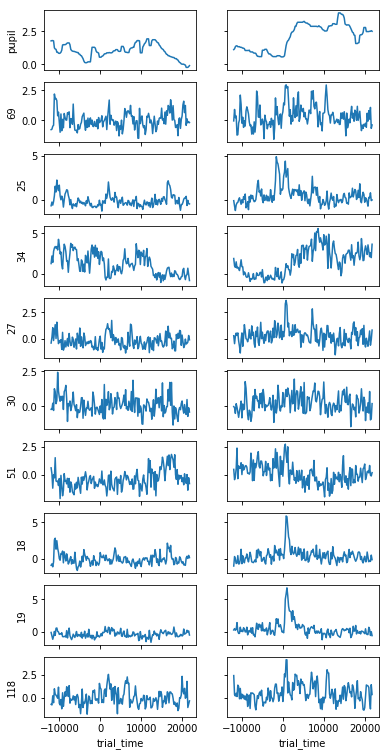

In [19]:
plt_name = 'sample_trace'

fig, axes = plt.subplots(nrows=10, ncols=2, sharex=True, sharey='row', figsize=(6, 13))

anim = 'J54'
neurons = [
    69, 25, 34,
    27, 30, 51,
    18, 19, 118,
]
# neurons = [
#     3, 5, 6, 7, 8, 9, 10, 11, 16,
#     17, 18, 19, 23, 28, 35, 39, 44, 49,
#     50, 52, 54, 55, 56, 58, 59, 60, 67,
#     68, 80, 88, 95, 99, 112, 114, 118, 123,
#     135, 144
# ]

t0 = 0
t1 = 0

d0 = behav_response.loc[('h2o'), (anim, t0, 'pupil')]
d0.index = d0.index.droplevel(0)
d0.plot(ax=axes[0, 0]);

d1 = behav_response.loc[('odor'), (anim, t1, 'pupil')]
d1.index = d1.index.droplevel(0)
d1.plot(ax=axes[0, 1]);

for n, (sub_ax, neur) in enumerate(zip(axes[1:, :], neurons)):
    y0 = neural_response.loc[('h2o'), (anim, t0, neur)]
    y0.index = y0.index.droplevel(0)
    y0.plot(ax=sub_ax[0])

    y1 = neural_response.loc[('odor'), (anim, t1, neur)]
    y1.index = y1.index.droplevel(0)
    y1.plot(ax=sub_ax[1]);
    
    sub_ax[0].set_ylabel(neur)

axes[0, 0].set_ylabel('pupil');

if plt_name:
    savefig(os.path.join(output_dir, plt_name + '.png'), fig)
    savefig(os.path.join(output_dir, plt_name + '.svg'), fig)

Saved ./data/headfixed_peanut\neural_cb.svg


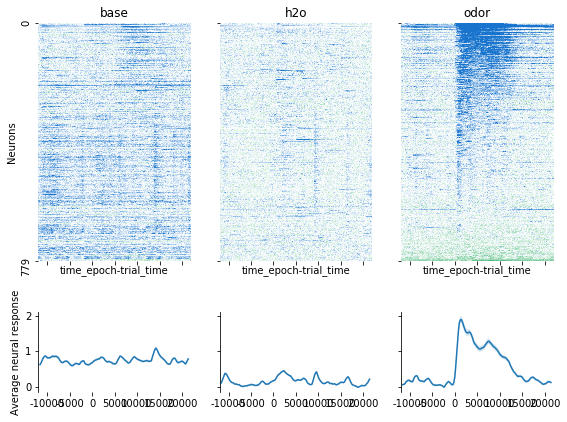

Saved ./data/headfixed_peanut\neural.png
Saved ./data/headfixed_peanut\neural.svg


In [20]:
# Neural plots

def activity_heatmap(data, plt_name=None, max_z=4):
    fig, axes  = plt.subplots(2, 3, sharey='row', sharex=True, gridspec_kw={'height_ratios':[3, 1]}, figsize=(8, 6))
    fig_cb, ax_cb = plt.subplots(figsize=(0.25, 4))

    ims = []
    for n, (grp, df) in enumerate(data.groupby(axis=0, level='epoch')):
        df.index = df.index.droplevel('epoch')
        
        # Plot heatmap
        C = df
        C.columns = np.arange(C.shape[1])
        sns.heatmap(C.T, ax=axes[0, n], cbar_ax=ax_cb, cmap=cmap, vmin=-max_z, vmax=max_z, yticklabels=C.shape[1] - 1)
        axes[0, n].set_title(grp)
        ims.append(axes[0, n].collections[0])

        # Plot mean trace
        Y = df.mean(axis=1).rolling(5, center=True).mean()
        E = df.sem(axis=1).rolling(5, center=True).mean()
        axes[1, n].plot(Y.as_matrix())
        X = axes[1, n].lines[0].get_xdata()
        axes[1, n].fill_between(X, Y + E, Y - E, alpha=0.2)
        axes[0, n].set_xticks(xticks)
        axes[0, n].set_xticklabels(xticklabels)
        
        # Remove spines
        axes[0, n].spines['top'].set_visible(False)
        axes[0, n].spines['right'].set_visible(False)
        axes[0, n].spines['bottom'].set_visible(False)
        axes[0, n].spines['left'].set_visible(False)
        axes[1, n].spines['top'].set_visible(False)
        axes[1, n].spines['right'].set_visible(False)
        axes[1, n].spines['bottom'].set_visible(False)

    axes[0, 0].set_ylabel('Neurons');
    axes[1, 0].set_ylabel('Average neural response');
    
    # Save colorbar
    if plt_name: savefig(plt_name + '_cb.svg', fig_cb)
    plt.close(fig_cb)
    
    fig.tight_layout()
    plt.show()
    if plt_name:
        savefig(plt_name + '.png', fig)
        for im in ims: im.remove()
        savefig(plt_name + '.svg', fig)

# Sorting
sort_metric = neural_response.loc[('odor', '2 response'), :].mean().mean(level=['subject', 'neuron'])
sort_ix = np.argsort(sort_metric.as_matrix())[::-1]

# Plot
plt_name = os.path.join(output_dir, 'neural')
activity_heatmap(neural_response.mean(axis=1, level=['subject', 'neuron']).iloc[:, sort_ix], plt_name)

Saved ./data/headfixed_peanut\neural_by_time_epoch.png
Saved ./data/headfixed_peanut\neural_by_time_epoch.svg


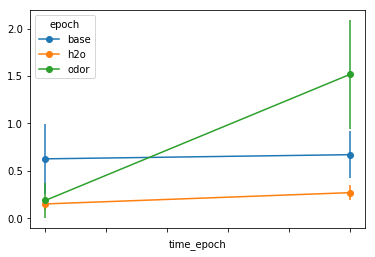

In [21]:
plt_name = 'neural_by_time_epoch'

neural_mean_by_time_epoch = neural_response.loc[(slice(None), ['0 pre', '2 response']), :].mean(axis=0, level=['epoch', 'time_epoch']).mean(axis=1, level=['subject']).unstack('epoch')

fig, ax = plt.subplots()
Y = neural_mean_by_time_epoch.mean(axis=1, level='epoch')
E = neural_mean_by_time_epoch.sem(axis=1, level='epoch')
Y.plot(ax=ax, yerr=E, marker='o')

if plt_name:
    savefig(os.path.join(output_dir, plt_name + '.png'), fig)
    savefig(os.path.join(output_dir, plt_name + '.svg'), fig)
    neural_mean_by_time_epoch.to_csv(os.path.join(output_dir, plt_name + '.csv'))

### Todo: stats

# Group neurons

## Statistical difference

_Should activity during exposure be subtracted by average before conveyor movement??_

In [22]:
thresh_data = neural_response.mean(axis=1, level=['subject', 'neuron'])
n_neurons = thresh_data.shape[1]
alpha = 0.05
p_thresh = alpha / n_neurons  # Bonferroni correction

grouping = pd.concat(
    [
        pd.DataFrame(index=['h2o', 'odor'], columns=thresh_data.columns, dtype=float),
        pd.DataFrame(index=['h2o', 'odor'], columns=thresh_data.columns, dtype=float),
        pd.DataFrame(index=['h2o', 'odor'], columns=thresh_data.columns, dtype=float),
    ],
    axis=0, keys=['p', 'sign', 'group']
)
for ep in ['h2o', 'odor']:
    for n, neuron in enumerate(thresh_data):
        X = thresh_data.loc[(ep, '0 pre'), neuron]
        Y = thresh_data.loc[(ep, '2 response'), neuron]
        if len(np.unique(np.concatenate((X, Y)))) > 1:
            _, grouping.loc[('p', ep), neuron] = scipy.stats.mannwhitneyu(X, Y)
            grouping.loc[('sign', ep), neuron] = np.sign(Y.mean() - X.mean())

        if grouping.loc[('p', ep), neuron] < p_thresh:
            grouping.loc[('group', ep), neuron] = grouping.loc[('sign', ep), neuron] 
        else:
            grouping.loc[('group', ep), neuron] = 0

Saved ./data/headfixed_peanut\neural-grouping.png
Saved ./data/headfixed_peanut\neural-grouping.svg


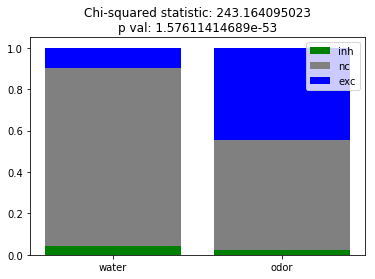

In [23]:
plt_name = 'neural-grouping'

response_counts = {ep: grouping.loc[('group', ep), :].value_counts() for ep in ['h2o', 'odor']}
resp = np.array([
    [response_counts['h2o'][-1], response_counts['odor'][-1]],
    [response_counts['h2o'][0], response_counts['odor'][0]],
    [response_counts['h2o'][1], response_counts['odor'][1]],
])
Y = resp / resp.sum(axis=0, dtype=float)
chi, p, _, _ = scipy.stats.chi2_contingency(resp)

# fig, axes = plt.subplots(ncols=2)
# for ax, (ep, counts) in zip(axes, response_counts.iteritems()):
#     ax.set_title('Responses to {}'.format(ep))
#     counts.plot.pie(ax=ax, colors=['gray', np.array([60, 179, 113])/255., np.array([24, 116, 205])/255.], autopct='%1.1f%%', wedgeprops={'lw': 5, 'ec': 'w'})
#     ax.axis('image')
#     centre_circle = plt.Circle((0, 0), 1 / 1.4142, color='none', fc='white')
#     ax.add_artist(centre_circle);

fig, ax = plt.subplots()
X = range(2)
ax.bar(X, Y[0], color='g', label='inh')
ax.bar(X, Y[1], bottom=Y[0], color='gray', label='nc')
ax.bar(X, Y[2], bottom=Y[0] + Y[1], color='b', label='exc')
ax.set_xticks(X)
ax.set_xticklabels(['water', 'odor'])
ax.legend()
ax.set_title('Chi-squared statistic: {}\np val: {}'.format(chi, p))

if plt_name:
    savefig(os.path.join(output_dir, plt_name + '.png'), fig)
    savefig(os.path.join(output_dir, plt_name + '.svg'), fig)

Saved ./data/headfixed_peanut\neural-trace-by-group.png
Saved ./data/headfixed_peanut\neural-trace-by-group.svg


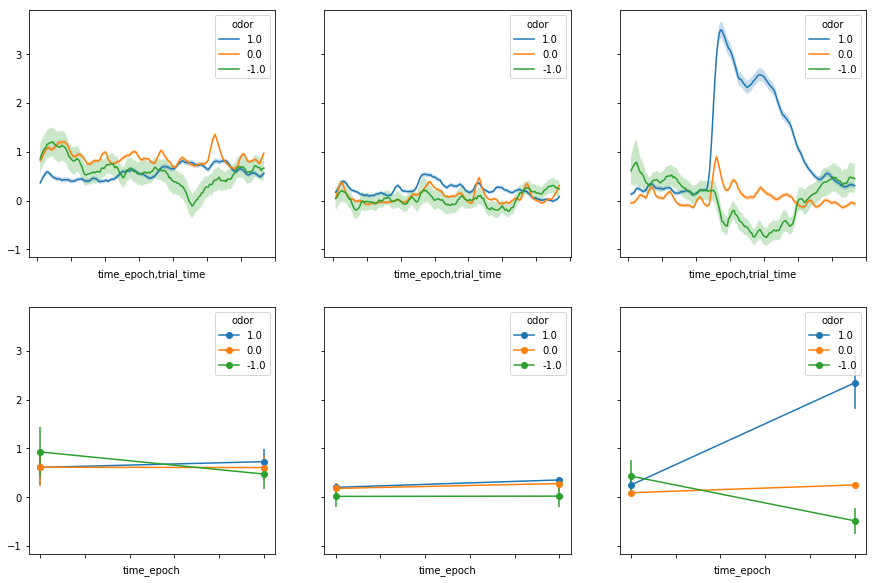

In [24]:
plt_name = 'neural-trace-by-group'

a = pd.concat([thresh_data.T, grouping.loc['group'].T], axis=1).set_index(['h2o', 'odor'], append=True).T
a.index = pd.MultiIndex.from_tuples(a.index, names=['epoch', 'time_epoch', 'trial_time'])

fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(15, 10))

for ax, (grp, df) in zip(axes.T, a.groupby(axis=0, level='epoch')):
    Y = a.loc[grp].mean(axis=1, level=['odor']).rolling(5, center=True).mean()
    E = a.loc[grp].sem(axis=1, level=['odor']).rolling(5, center=True).mean()
    Y.plot(ax=ax[0]);
    X = ax[0].lines[0].get_xdata()
    
    for n in range(Y.shape[1]):
        y = Y.as_matrix()[:, n]
        e = E.as_matrix()[:, n]
        ix = ~ (np.isnan(y) + np.isnan(e))
        ax[0].fill_between(X[ix], y[ix] - e[ix], y[ix] + e[ix], alpha=0.25)
    
    Y1 = a.loc[(grp, ['0 pre', '2 response']), :].mean(axis=0, level='time_epoch').mean(axis=1, level=['subject', 'odor'])
    y = Y1.mean(axis=1, level=['odor'])
    e = Y1.sem(axis=1, level=['odor'])
    y.plot(ax=ax[1], yerr=e, marker='o')
    
    if plt_name:
        avg_data.to_csv(os.path.join(output_dir, plt_name + grp + '.csv'))

if plt_name:
    savefig(os.path.join(output_dir, plt_name + '.png'), fig)
    savefig(os.path.join(output_dir, plt_name + '.svg'), fig)

## Clustering

In [ ]:
pca_data = neural_response.loc[(['h2o', 'odor'], ['0 pre', '2 response', '4 post']), :].T
pca_data = neural_response.loc[['h2o', 'odor'], :].mean(axis=1, level=['subject', 'neuron']).T

pca = decomposition.PCA()
transformed = pca.fit_transform(pca_data)

# Plots
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

# Plot explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)
axes[0].plot(cum_var);
axes[0].set_title('Cumulative explained variance');
axes[0].set_ylabel('Proportion of variance');
axes[0].set_xlabel('Ordered PCs');

# Plot data wrt first components
axes[1].scatter(transformed[:, 0], transformed[:, 1]);
axes[1].set_xlabel('PC0');
axes[1].set_ylabel('PC1');
axes[1].axis('equal');

In [ ]:
pca_data.shape

In [ ]:
pca.components_.shape

In [ ]:
plt.plot(pca.components_[0])

In [ ]:
plt.plot(pca.components_[1])

In [ ]:
# Find optimal parameters

cluster_data = transformed[:, :5]
max_n_clusters = 10
silhouette_scores = np.nan * np.ones((4, max_n_clusters))

for n, n_n in enumerate([2, 10, 50, 100]):
    for n_clusters in range(2, max_n_clusters):
        model = cluster.SpectralClustering(affinity='rbf', n_neighbors=n_n, n_clusters=n_clusters)
        model.fit(cluster_data)
        silhouette_scores[n, n_clusters] = silhouette_score(cluster_data, model.labels_, metric='cosine')

plt.pcolor(silhouette_scores, cmap='bwr', vmin=-1, vmax=1);
plt.colorbar();

# Correlation

In [25]:
features = ['pupil', 'track']

behav_corr_data = behav_response.loc[(slice(None), ['0 pre', '2 response', '4 post']), :].unstack('epoch').stack('trial')
neural_corr_data = neural_response.loc[(slice(None), ['0 pre', '2 response', '4 post']), :].unstack('epoch').stack('trial')

behav_corr_data = behav_corr_data.groupby(level='time_epoch').apply(lambda x: x.reset_index(drop=True))
neural_corr_data = neural_corr_data.groupby(level='time_epoch').apply(lambda x: x.reset_index(drop=True))

corrs = np.zeros((4, neural_corr_data.shape[1]), dtype=float) * np.nan
corrs = pd.DataFrame(corrs, index=pd.MultiIndex.from_product([features, ['r', 'p']]), columns=neural_corr_data.columns)
for obs_key in neural_corr_data:
    subj, neuron, epoch = obs_key
    obs_neural = neural_corr_data[obs_key]
    for feature in features:
        obs_behav = behav_corr_data[subj, feature, epoch]
        na_ix = obs_behav.isna() | obs_neural.isna()
        corrs.loc[feature, obs_key] = scipy.stats.pearsonr(obs_behav[~na_ix].dropna(), obs_neural[~na_ix].dropna())

In [26]:
datasets[('h2o', -1)].plot.hist(cumulative=True)

NameError: name 'datasets' is not defined

In [ ]:
custom.cdf(datasets[('h2o', -1)].as_matrix().astype(float))

In [ ]:
b.loc[('pupil', 'r', 'h2o'), (slice(None), slice(None), slice(None), -1)]

Saved ./data/headfixed_peanut\neural-behav-corr-distro.png
Saved ./data/headfixed_peanut\neural-behav-corr-distro.svg


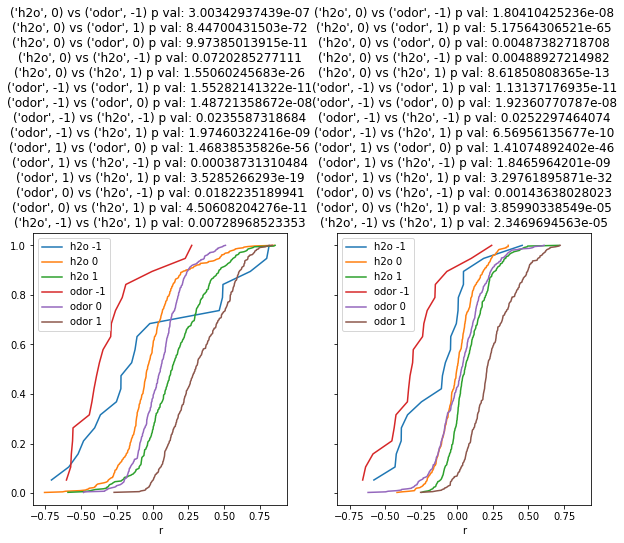

In [27]:
# Plot

b = pd.concat([corrs.stack('epoch'), grouping.loc['group']], axis=0).T.set_index(['h2o', 'odor'], append=True).T
b.index = pd.MultiIndex.from_tuples(b.index, names=['feature', 'stat', 'epoch'])

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
for n, feature in enumerate(features):
#     ctrl = corrs.loc[(feature, 'r'), (slice(None), slice(None), 'h2o')].dropna()
#     exp = corrs.loc[(feature, 'r'), (slice(None), slice(None), 'odor')].dropna()
    datasets = {}
    for ep in ['h2o', 'odor']:
        for grp in [-1, 0, 1]:
            datasets[(ep, grp)] = Y = b.loc[(feature, 'r', ep), (slice(None), slice(None), slice(None), grp)].dropna()
            custom.cdf(Y, ax=axes[n], label=' '.join([ep, str(grp)]), ignore_nan=False)
            if ep == 'h2o' and grp == -1:
                Y_ = Y
    axes[n].legend()
    axes[n].set_xlabel('r')

    pairs = itertools.combinations(datasets.keys(), 2)
    post_hocs = []
    for (x_ep, x_grp), (y_ep, y_grp) in pairs:
        xset = b.loc[(feature, 'r', x_ep), (slice(None), slice(None), slice(None), x_grp)]
        yset = b.loc[(feature, 'r', y_ep), (slice(None), slice(None), slice(None), y_grp)]
        w, p = scipy.stats.mannwhitneyu(xset, yset)
        post_hocs.append('{} vs {} p val: {}'.format((x_ep, x_grp), (y_ep, y_grp), p))
    axes[n].set_title('\n'.join(post_hocs))

plt_name = 'neural-behav-corr-distro'
if plt_name:
    savefig(os.path.join(output_dir, plt_name + '.png'), fig)
    savefig(os.path.join(output_dir, plt_name + '.svg'), fig)

# GLM 

In [ ]:
# Define functions

def ar_terms(signal, shift=1, level=None, name='ar'):
    '''Define autoregressive terms
    Shift timestamps in index to create autoregressive terms.
    '''
    ar = signal.copy()
    if level:
        old_index = zip(*signal.index.tolist())
        new_ts = [x + shift for x in old_index[level]]
        new_index = list(old_index)
        new_index[level] = new_ts
        ar.index = pd.MultiIndex.from_tuples(zip(*new_index))
    else:
        old_index = signal.index
        ar.index = [x + shift for x in old_index]

    ar.name = name
    return ar


def plot_model(output_file, W_curr, B_curr, Y_curr, y, train_ix, y_predicted):
    
    rez = Y_curr - y[train_ix]
    
    fig, ax = plt.subplots(2, 4, figsize=(14, 4));

    ax[0][0].plot(y[train_ix]);
    ax[0][0].plot(Y_curr);
    ax[0][0].set_ylabel("Fluorescence value")
    ax[0][0].set_xlabel("Observations | frames")

    ax[0][1].scatter(y[train_ix], Y_curr);
    ax[0][1].set_ylabel("Predicted");
    ax[0][1].set_xlabel("Training value");

    ax[0][2].plot(rez);
    ax[0][2].set_ylabel("Residual");
    ax[0][2].set_xlabel("Observations (Time)");
    
    ax[0][3].scatter(rez, y[train_ix]);
    ax[0][3].set_ylabel("Residual");
    ax[0][3].set_xlabel("Training value");
    
    ax[1][3].plot(cost_hx);
    ax[1][3].set_ylabel("Cost");
    ax[1][3].set_xlabel("Iteration");

    ax[1][0].plot(y_predicted);
    ax[1][0].plot(y[~train_ix]);
    ax[1][0].set_ylabel("Fluorescence value");
    ax[1][0].set_xlabel("Observations | frames");

    ax[1][1].scatter(y[~train_ix], y_predicted);
    ax[1][1].set_ylabel("Predicted");
    ax[1][1].set_xlabel("Test value");
    
    fig.tight_layout()
    fig.savefig(output_file)
    plt.close()
    
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [ ]:
# Create and normalize features

col_no_norm = [
    'rail_home',
    'rail_leave',
    'time',
    'trials',
    'proximity'
]

behav_norm = behav.copy()
behav_norm[('', '', 'proximity')] = [1 if ep == '2 response' else 0 for ep in behav.reset_index('time_epoch')['time_epoch']]
features_print = set()
for column in behav:
    features_print.add(column[2])
    if column[2] in col_no_norm:
        pass
#         behav_norm[column] = (behav_norm[column] > 0).astype(int)
    else:
        behav_norm[column] = (behav[column] - behav[column].mean()) * (1 /  (behav[column].std() or 1))  # if std is 0, entire column is 0
behav_norm = behav_norm.sort_index(axis=1)

print(features_print)

In [ ]:
# Choose features

features = [
    'pupil',
    'track',
    'proximity',
]

n_features = len(features)
n_coeffs = n_features + 1

In [ ]:
neural_glm = neural.loc[(['h2o', 'odor'], ['0 pre', '2 response']), (slice(None), trial_slice)].unstack('epoch')
neural_glm.columns = neural_glm.columns.reorder_levels(['subject', 'trial', 'epoch', 'neuron'])
neural_glm = neural_glm.sort_index(axis=1)
ar1 = ar_terms(neural_glm, shift=200, level=1)
ar2 = ar_terms(neural_glm, shift=400, level=1)

behav_glm = behav_norm.unstack('epoch').loc[:, (slice(None), [trial_slice, ''], features, ['h2o', 'odor'])]
behav_glm.columns = behav_glm.columns.reorder_levels(['subject', 'trial', 'epoch', 'feature'])
behav_glm = behav_glm.sort_index(axis=1)

### Linear regression

In [ ]:
# Define model

# Correct variable names
renamer = {
    label: '_'.join(str(label).translate(None, '()<>/-').split())
    for label, _ in behav_glm.groupby(axis=1, level='feature')
}
behav_glm = behav_glm.rename(columns=renamer)
features = [renamer[f] if f in renamer.keys() else f for f in features]

# Create formula
formula = 'neural ~ ' + ' + '.join(features)

print(formula)

In [ ]:
# Train model

n_cells = neural_glm.shape[1]

file_ts = time.strftime('%Y%m%d-%H%M%S')
output_file_base = os.path.join(output_dir, 'linear-models', file_ts)
if not os.path.isdir(output_file_base):
    os.makedirs(output_file_base)

coeffs = np.nan * np.zeros((n_cells, n_coeffs))
coeff_index = []
datas = []
models = []
results = pd.DataFrame()

for cell in xrange(n_cells):
    # Identify cell
    anim, trial, epoch, anim_cell = neural_glm.columns[cell]
    coeff_index.append([anim, trial, epoch, anim_cell])
    
    # Create cell's data for regression
    neural_list = [neural_glm.iloc[:, cell].rename('neural')]
    if 'ar1' in formula: neural_list += [ar1.iloc[:, cell].rename('ar1')]
    if 'ar2' in formula: neural_list += [ar2.iloc[:, cell].rename('ar2')]
    neural_cell_data = pd.concat(neural_list, axis=1)
    behav_cell_data = behav_glm.loc[:, ([anim, ''], [trial, ''], epoch) if not behav_glm.empty else pd.DataFrame([])]
    behav_cell_data.columns = behav_cell_data.columns.droplevel(['subject', 'trial', 'epoch'])
    data = pd.concat([neural_cell_data, behav_cell_data], axis=1)
    data = data.dropna()  # Can't handle nan's
    datas.append(data)
    
    # Regress
    model = smf.ols(data=data, formula=formula).fit()
    result = pd.concat(
        [
            model.params,
            model.pvalues,
            pd.Series([model.rsquared, model.rsquared_adj], index=['r_squared', 'r_squared_adj']),
            pd.Series(model.aic, index=['aic'])
        ],
        axis=0, keys=['coefficients', 'p', 'r_squared', 'model']
    )
    result = result.rename((anim, trial, epoch, anim_cell))
    
    models.append(model)
    results = pd.concat([results, result], axis=1)

results.columns = pd.MultiIndex.from_tuples(results.columns, names=['subject', 'experiment', 'epoch', 'neuron'])
results = results.T

In [ ]:
n = 40
models[n].resid.plot()
models[n].fittedvalues.plot()
datas[n]['neural'].plot()

# Old

## Linear regression
- Data 

In [ ]:
# Format data
neural_glm = neural.copy()
neural_glm.columns = neural_glm.columns.droplevel('order')
neural_glm = neural_glm.stack(level=['trial'])
behav_glm = behav.copy()
behav_glm.columns = behav_glm.columns.droplevel('order')
behav_glm = behav_glm.stack(level=['trial'])

# Autoregressive terms
neural_ar1 = ar_terms(neural_glm, shift=200, level=1)
neural_ar2 = ar_terms(neural_glm, shift=400, level=1)

# Filter by matched neurons
# neural_glm_paired = neural_glm.stack(level='experiment')
# neural_glm_paired = neural_glm.dropna(axis=1)

In [ ]:
# Model each neuron
models = {}
for cell in neural_glm:
    # Create dataframe for cell
    data_for_cell = behav_glm[cell[:-1]].copy()
    data_for_cell['fluorescence'] = neural_glm[cell]
    data_for_cell['ar1'] = neural_ar1[cell]
    data_for_cell['ar2'] = neural_ar2[cell]

    # Add in_trial variable
    data_for_cell['in_trial'] = False
    data_for_cell.loc[(slice(None), response_slice), 'in_trial'] = True
    
    # Model
    data = data_for_cell.loc[(['h2o', 'odor'], [base_slice, response_slice]), slice(None)]
    models[cell] = smf.ols('fluorescence ~ pupil*in_trial + track*in_trial', data=data).fit()

In [ ]:
models.values()[0].summary()

In [ ]:
# Gather coefficients
coeffs = pd.concat({cell: model.params for cell, model in models.iteritems()}, axis=1)
coeffs.columns.names = ['epoch', 'subject', 'plane', 'neuron']
coeffs.index.name = 'feature'
coeffs = coeffs.sort_index(axis=1)

coeffs = coeffs.stack(level='epoch')
# coeffs = coeffs.reorder_levels(['epoch', 'feature'], axis=0)
coeffs = coeffs.sort_index(axis=0)

In [ ]:
scipy.stats.pearsonr(coeffs.dropna(axis=1).loc[('pupil', 'TMT')], coeffs.dropna(axis=1).loc[('pupil', 'PNT')])

In [ ]:
coeffs.dropna(axis=1).transpose().plot.scatter(x=('pupil', 'TMT'), y=('pupil', 'PNT'))

In [ ]:
# Plot coefficient distribution

opts0 = {
    'bins': 20,
    'range': (-1, 1),
    'cumulative': False,
    'normed': True,
#     'histtype': 'step'
}
opts = {
    'bins': 250,
    'range': (-1, 1),
    'cumulative': True,
    'normed': True,
    'histtype': 'step'
}

colors = ['gray', 'orange']

Y0 = coeffs.loc[(var, 'PNT')]
Y1 = coeffs.loc[(var, 'TMT')]

# Plot
fig, ax = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [3, 3, 1]}, figsize=(8, 8))

(Y1 - Y0).plot.hist(ax=ax[0], color='orange', **opts0)
Y0.plot.hist(ax=ax[1], color=colors[0], **opts)
Y1.plot.hist(ax=ax[1], color=colors[1], **opts)

bplot = ax[2].boxplot([Y0, Y1], widths=0.6, notch=True, vert=False, whis=[5, 95], showfliers=False, patch_artist=True)
ax[2].set_yticklabels(['control', 'stim'])
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

_, pval = scipy.stats.wilcoxon(Y0, Y1)
fig.suptitle("p value: {}".format(pval));

In [ ]:
%%R -i data_for_cell
print(data_for_cell)
model <- lm(fluorescence ~ pupil + track, data=data_for_cell)
coeffs <- model$coefficients
# summary(model)

In [ ]:
# Setup data

# good_index = [slice(pre, -6200), slice(0, 9800), slice(16000, post)]  # Remove time during odor movement
good_index = [base_slice, response_slice]  # Only baseline and odor presentation
# good_index = [slice(0, 9800), slice(16000, post)]  # Remove time during odor movement

# Normalize
X = behav.loc[(['h2o', 'odor'], good_index), slice(None)].stack(level='trial').reorder_levels([0, 2, 1], axis=0).sort_index()
X -= X.mean()
X /= X.std()

Y = neural.loc[(['h2o', 'odor'], good_index), slice(None)].stack(level='trial').reorder_levels([0, 2, 1], axis=0).sort_index()

This model uses and odor proximity as a dummy variables. TMT and water are modeled separately. The equation becomes:

\begin{align}
y & = \beta_0 x_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 +
      \beta_5 x_1 x_3 + \beta_6 x_1 x_4 + \beta_7 x_2 x_3 + \beta_8 x_1 x_4 +
      \beta_9 x_1 x_2 x_3 + \beta_{10} x_1 x_2 x_4 \\
  & = (\beta_0 + \beta_3 x_3) \cdot x_0 + (\beta_1 + \beta_4 x_4) \cdot x_1 + (\beta_2 + \beta_5 x_5) \cdot x_2
\end{align}

where $x_0$ is the intercept, $x_1$ is pupil, $x_2$ is movement, and $x_3$ is odor proximity.

This model uses TMT exposure as a dummy variable. The equation becomes:

\begin{align}
y & = \beta_0x_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_1x_3 + \beta_5x_2x_3 \\
  & = (\beta_0 + \beta_3 x_3) \cdot x_0 + (\beta_1 + \beta_4 x_4) \cdot x_1 + (\beta_2 + \beta_5 x_5) \cdot x_2
\end{align}

where $x_0$ is the intercept, $x_1$ is pupil, $x_2$ is movement, and $x_3$ is TMT exposure.

This model uses odor proximity as a dummy variable. The equation becomes:

\begin{align}
y & = \beta_0x_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_1x_3 + \beta_5x_2x_3 \\
  & = (\beta_0 + \beta_3 x_3) \cdot x_0 + (\beta_1 + \beta_4 x_4) \cdot x_1 + (\beta_2 + \beta_5 x_5) \cdot x_2
\end{align}

where $x_0$ is the intercept, $x_1$ is pupil, $x_2$ is movement, and $x_3$ is if odor is close.

In [ ]:
# Define model

features = ['close', 'pupil', 'track']
interactions = [
#     'tmt * pupil', 'tmt * track',
    'close * pupil', 'close * track',
#     'tmt * close * pupil', 'tmt * close * track'
]
formula = 'neural ~ ' + ' + '.join(features + interactions)

print(formula)

In [ ]:
# Add  dummy variables

tmt_ix = ('all', 'none', 'tmt')       # Column names for tmt
X[tmt_ix] = X.index.labels[0] == 2    # Add TMT variable
X[tmt_ix] = X[tmt_ix].astype(int)

close_index = np.arange(0, 10000, 200)
close_ix = ('all', 'none', 'close')
X[close_ix] = [1 if ix[2] in close_index else 0 for ix in X.index]

In [ ]:
# Model

models = {}
for cell in Y:
# for cell  [('PNOCJ52', 'P1', 100)]:
    subj, plane, cellno = Y[cell].name

    Y_ = Y.loc[slice('ctrl', 'stim'), cell]
    X_ = X.loc[slice('ctrl', 'stim'), (subj, plane, features)]
    Xt = X.loc[slice('ctrl', 'stim'), [close_ix]]
    data = pd.concat([Y_, Xt, X_], axis=1)
    data.columns = data.columns.droplevel([0, 1])
    data.columns = ['neural'] + data.columns[1:].tolist()

    # Model
    for epoch in ['ctrl', 'stim']:
        models[(epoch, ) + cell] = smf.ols(data=data.loc[epoch], formula=formula).fit()

In [ ]:
# PCA

pca_data = coeffs.T
pca = decomposition.PCA()
transformed = pca.fit_transform(pca_data)

In [ ]:
plt.scatter(transformed[:, 0], transformed[:, 1]);

### Neural correlation

In [ ]:
# Correlate neurons within subjects

# far_ix = [slice(pre, -6200), slice(16000, post)]
far_ix = slice(pre, -6200)
close_ix = slice(0, 9800)

corr_matrices = {}
corr_lists = {}

for img_plane, df in Y.groupby(axis=1, level=[0, 1]):
    df_corr_c = df.loc[('stim', slice(None), far_ix), slice(None)].corr()
    df_corr_s = df.loc[('stim', slice(None), close_ix), slice(None)].corr()
    n_cells = df_corr_c.shape[0]
    
    # Drop levels
    df_corr_c.index = df_corr_c.index.droplevel(level=[0, 1])
    df_corr_s.index = df_corr_s.index.droplevel(level=[0, 1])
    df_corr_c.columns = df_corr_c.columns.droplevel(level=[0, 1])
    df_corr_s.columns = df_corr_s.columns.droplevel(level=[0, 1])
    
    corr_matrices[img_plane] = (df_corr_c, df_corr_s)
    
    corr_lists[img_plane] = {
        (df_corr_c.index[i], df_corr_c.columns[j]): [df_corr_c.iloc[i, j], df_corr_s.iloc[i, j]]
        for i in range(n_cells)
        for j in range(n_cells)[(i + 1):]
    }

In [ ]:
plane = ('PNOCJ31', 'P1')
corr_vals = np.array(corr_lists[plane].values()).T

# Plot
fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10, 5))

fig.suptitle(', '.join(plane))
hist_opts = {
    'bins': 250,
    'range': (-1, 1),
    'normed': True,
    'cumulative': True,
    'histtype': 'step'
}

ax[0].hist(corr_vals[0], color='gray', **hist_opts);
ax[0].hist(corr_vals[1], color='orange', **hist_opts);
# ax[0].axvline(x=np.median(corr_vals[0]), ls='--', color='gray')
# ax[0].axvline(x=np.median(corr_vals[1]), ls='--', color='orange')

ax[1].boxplot(corr_vals.T, widths=0.6, notch=True, vert=False, whis=[5, 95], showfliers=False)
ax[1].set_yticklabels(['control', 'stim'])

_, pval = scipy.stats.ttest_rel(corr_vals[0], corr_vals[1])
print("p value: {}".format(pval))

In [ ]:
# Clustering


### Graph

In [ ]:
# Create adjacency matrix

adj = [mat.copy().as_matrix() for mat in corr_matrices[plane]]
for n, mat in enumerate(adj):
    np.fill_diagonal(mat, 0)

adj_filt = [a.copy() for a in adj]
# cutoff_ix = [mat.abs() < 0.5 for mat in corr_matrices[plane]]  # filter strong correlations
cutoff_ix = [mat < 0.5 for mat in corr_matrices[plane]]  # filter strong POSITIVE correlations

for n, mat in enumerate(adj_filt):
    mat[cutoff_ix[n]] = 0

# for n, _ in enumerate(adj):
#     adj[n] = adj[n].astype([('corr', float)])
#     adj_filt[n] = adj_filt[n].astype([('corr', float)])

# Plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
ax[0][0].pcolormesh(adj[0], cmap='bwr', vmin=-1, vmax=1)
ax[0][1].pcolormesh(adj[1], cmap='bwr', vmin=-1, vmax=1)
ax[1][0].pcolormesh(adj_filt[0], cmap='bwr', vmin=-1, vmax=1)
ax[1][1].pcolormesh(adj_filt[1], cmap='bwr', vmin=-1, vmax=1)
# custom.hinton(adj[0], max_weight=1, ax=ax[0][0])
# custom.hinton(adj[1], max_weight=1, ax=ax[0][1])
# custom.hinton(adj_filt[0], max_weight=1, ax=ax[1][0])
# custom.hinton(adj_filt[1], max_weight=1, ax=ax[1][1])

for a in ax:
    for b in a:
        b.axis('image')

In [ ]:
# Create graph

graphs = [nx.from_numpy_matrix(mat, create_using=nx.Graph()) for mat in adj_filt]

# Copy attribute 'weight' to 'corr'
for G in graphs:
    nx.set_edge_attributes(G, 'corr', {(i, j): wt for i, j, wt in G.edges(data='weight')})

In [ ]:
# Add more attributes

for G in graphs:
    nx.set_node_attributes(G, 'label', {n: number for n, number in enumerate(corr_matrices[plane][1].index)})
    nx.set_node_attributes(G, 'shape', 'circle')
    nx.set_node_attributes(G, 'style', 'filled')
    nx.set_node_attributes(G, 'fillcolor', '#ffffff')
    
#     edge_min = np.min([corr for _, _, corr in G.edges(data='corr')])
    edge_wt = {(i, j): np.power(10, corr) + 1 for i, j, corr in G.edges(data='corr')}
    edge_wd = {(i, j): np.abs(corr)**3 * 10 for i, j, corr in G.edges(data='corr')}
    edge_color = {
        (i, j):
            '#ff{0}{0}'.format(format(np.round(255 * (1 + corr)).astype(int), '02x')) if corr < 0 else
            '#{0}{0}ff'.format(format(np.round(255 * (1 - corr)).astype(int), '02x'))
        for i, j, corr in G.edges(data='corr')
    }

#     nx.set_edge_attributes('len', {key: 1. / np.square(1000 * val) for key, val in weight.iteritems()})
    nx.set_edge_attributes(G, 'weight', edge_wt)
    nx.set_edge_attributes(G, 'penwidth', edge_wd)
    nx.set_edge_attributes(G, 'color', edge_color)

In [ ]:
pydot_files = ['ctrl.png', 'stim.png']
dot_graphs = [custom.nx_to_pydot(G, pydot_file=F, ext='png', prog='neato') for G, F in zip(graphs, pydot_files)]

In [ ]:
# Graph by control

fig, ax = plt.subplots(ncols=2, figsize=(18, 7))
for a in ax:
    a.axis('off')

pos = nx.drawing.nx_agraph.graphviz_layout(graphs[0], prog='neato')
# pos = nx.circular_layout(graphs[0])

nx.draw_networkx_nodes(graphs[0], pos, ax=ax[0], node_color='gray');
nx.draw_networkx_nodes(graphs[1], pos, ax=ax[1], node_color='orange');

nx.draw_networkx_labels(graphs[0], pos, ax=ax[0], node_color='gray');
nx.draw_networkx_labels(graphs[1], pos, ax=ax[1], node_color='orange');

edge_width_ctrl = np.array([w for _, _, w in graphs[0].edges(data='weight')])
nx.draw_networkx_edges(graphs[0], pos, ax=ax[0], width=edge_width_ctrl * 3, edge_cmap=plt.cm.bwr, edge_vmin=-1, edge_vma=1, edge_color=edge_width_ctrl)

edge_width_stim = np.array([w for _, _, w in graphs[1].edges(data='weight')])
nx.draw_networkx_edges(graphs[1], pos, ax=ax[1], width=edge_width_stim * 3, edge_cmap=plt.cm.bwr, edge_vmin=-1, edge_vma=1, edge_color=edge_width_stim)

In [ ]:
# Graph by stim

fig, ax = plt.subplots(ncols=2, figsize=(18, 7))
for a in ax:
    a.axis('off')

pos = nx.drawing.nx_agraph.graphviz_layout(graphs[1], prog='neato')
# pos = nx.circular_layout(graphs[0])

nx.draw_networkx_nodes(graphs[0], pos, ax=ax[0], node_color='gray');
nx.draw_networkx_nodes(graphs[1], pos, ax=ax[1], node_color='orange');

nx.draw_networkx_labels(graphs[0], pos, ax=ax[0], node_color='gray');
nx.draw_networkx_labels(graphs[1], pos, ax=ax[1], node_color='orange');

edge_width_ctrl = np.array([w for _, _, w in graphs[0].edges(data='weight')])
nx.draw_networkx_edges(graphs[0], pos, ax=ax[0], width=edge_width_ctrl * 3, edge_cmap=plt.cm.bwr, edge_vmin=-1, edge_vma=1, edge_color=edge_width_ctrl)

edge_width_stim = np.array([w for _, _, w in graphs[1].edges(data='weight')])
nx.draw_networkx_edges(graphs[1], pos, ax=ax[1], width=edge_width_stim * 3, edge_cmap=plt.cm.bwr, edge_vmin=-1, edge_vma=1, edge_color=edge_width_stim)

### Clustering

In [ ]:
good_index

In [ ]:
Y = neural.loc[(['ctrl', 'stim'], good_index), slice(None)].xs(0, axis=1, level='trial')

In [ ]:
# PCA

pca_data = Y.T
pca = decomposition.PCA()
transformed = pca.fit_transform(pca_data)

# Plots
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

# Plot explained variance
Yvar = np.cumsum(pca.explained_variance_ratio_)
ax[0].plot(Yvar);
ax[0].set_title("Explained variance");

# Plot data wrt first components
ax[1].scatter(transformed[:, 0], transformed[:, 1]);
ax[1].set_xlabel('PC0');
ax[1].set_ylabel('PC1');
ax[1].axis('equal');

In [ ]:
# Find optimal parameters

cluster_data = transformed[:, :5]
max_n_clusters = 10
silhouette_scores = np.nan * np.ones((4, max_n_clusters))

for n, n_n in enumerate([2, 10, 50, 100]):
    for n_clusters in range(2, max_n_clusters):
        model = cluster.SpectralClustering(affinity='rbf', n_neighbors=n_n, n_clusters=n_clusters)
        model.fit(cluster_data)
        silhouette_scores[n, n_clusters] = silhouette_score(cluster_data, model.labels_, metric='cosine')

plt.pcolor(silhouette_scores, cmap='bwr', vmin=-1, vmax=1);
plt.colorbar();

In [ ]:
clustering = cluster.SpectralClustering(
    n_clusters=2,
    eigen_solver='arpack',
    affinity="nearest_neighbors"
)
clustering.fit(coeffs.T)
clustering.labels_

In [ ]:
plt.hist(coeffs.loc['Intercept', 'ctrl'], bins=500, range=(-5, 5), normed=True, cumulative=True, histtype='step', color='gray');
plt.hist(coeffs.loc['Intercept', 'stim'], bins=500, range=(-5, 5), normed=True, cumulative=True, histtype='step', color='orange');

In [ ]:
plt.scatter(x=coeffs.loc['close[T.True]:track', 'ctrl'], y=coeffs.loc['close[T.True]:track', 'stim'])

In [ ]:
Y0 = coeffs.loc['close[T.True]:track', 'ctrl'].mean()
Y1 = coeffs.loc['close[T.True]:track', 'stim'].mean()
E0 = coeffs.loc['close[T.True]:track', 'ctrl'].sem()
E1 = coeffs.loc['close[T.True]:track', 'stim'].sem()

plt.bar(range(2), [Y0, Y1], yerr=[E0, E1]);

In [ ]:
scipy.stats.ttest_rel(coeffs.loc['close[T.True]:track', 'ctrl'], coeffs.loc['close[T.True]:track', 'stim'])

In [ ]:
from scipy.stats.stats import pearsonr
x = data.dropna()
pearsonr(x['neural'], x['pupil'])

In [ ]:
np.corrcoef(x['pupil'], x['track'])

In [ ]:
plt.scatter(data.loc['stim', 'track'], data.loc['stim', 'neural'])

In [ ]:
data['pupil'].plot()

In [ ]:
models[cell].params

In [ ]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

cell = ('PNOCJ52', 'P1', 5)

fig, ax = plt.subplots(ncols=3, figsize=(15, 6))
Y_ = Y[cell].unstack(level=1).loc['stim', 1]
Y_.plot(ax=ax[0])

Yp_ = models[cell].fittedvalues.unstack(level=1).loc['stim', 1]
prstd, iv_l, iv_u = wls_prediction_std(models[cell])
Yp_.plot(ax=ax[0])
ax[0].fill_between(Yp_.index, iv_l.unstack(level=1).loc['stim', 1], iv_u.unstack(level=1).loc['stim', 1], alpha=0.3)

ax[1].scatter(Y_, Yp_);
ax[1].axis('equal')
ax[1].autoscale(False, 'both')
axlim = (min(ax[1].get_xlim() + ax[1].get_ylim()), max(ax[1].get_xlim() + ax[1].get_ylim()))
ax[1].plot(axlim, axlim, ls='--', color='gray')

ax[2].scatter(Y_, Y_ - Yp_)
ax[2].autoscale(False, 'both')
axlim = (min(ax[2].get_xlim() + ax[2].get_ylim()), max(ax[2].get_xlim() + ax[2].get_ylim()))
ax[2].plot(axlim, axlim, ls='--', color='gray')


In [ ]:
models[cell].summary()

In [ ]:
Y_.plot()
X_[('PNOCJ52', 'P1', 'pupil')].plot()
(X_[('PNOCJ52', 'P1', 'track')]).plot()
plt.show()

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

### xarray

In [ ]:
df_trials.to_xarray()

## Junk

In [ ]:
time_limit = 10
bin_size = 2
ts = np.arange(0, time_limit, bin_size)
nbins = len(ts)
df = pd.DataFrame(
    index=pd.MultiIndex.from_tuples(
        zip(['pre'] * nbins, ts) + zip(['stim'] * nbins, ts) + zip(['post'] * nbins, ts),
        names=['epoch', 'time']
    ),
    columns=pd.MultiIndex(
        levels=[[], []],
        labels=[[], []],
        names=['animal', 'variable']
    )
)
df

In [ ]:
df.set_value('pre', ('id', 'var'), np.arange(nbins))

In [ ]:
df = pd.DataFrame(
#     np.random.random((6, 4)),
    index=pd.MultiIndex.from_tuples(
        zip(['a'] * 3, range(3)) + zip(['b'] * 3, range(3))
    )
)
df

In [ ]:
df.set_value('a', 's1', np.random.random(3))